In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
import cv2
import os

# Import image

First we import our image, we totally have 1500 low resolution images and corresponding high resolution image

In [5]:
import glob

start = time.time()

LR = [cv2.imread(file).astype(np.float32) for file in glob.glob("../data/train_set/LR/*.jpg")]
HR = [cv2.imread(file).astype(np.float32) for file in glob.glob("../data/train_set/HR/*.jpg")]
end = time.time()
print('Time:',end - start)

Time: 14.709250926971436


###### Metric

We are going to use PSNR as our final measurement metric.

In [6]:
import math

def MSE(y_true,y_predict):
    temp = (y_true - y_predict)**2
    return sum(temp.reshape(-1))/(temp.shape[0]*temp.shape[1]*temp.shape[2])

def psnr(y_true,y_predict):
    temp = (y_true - y_predict)**2
    mse = sum(temp.reshape(-1))/(temp.shape[0]*temp.shape[1]*temp.shape[2])
    MAXI = 255
    return 20*math.log10(MAXI)-10*math.log10(mse)

###### Define basic parameters

We have 3 channels (RBG), and set seed and define the number of pixels taken from each picture to be our training data.

In [7]:
seed = 1000
channels = np.arange(3)
sample_size = 100

# Use OpenCV Function

We implement the *INTER_NEAREST* function in OpenCV to see the performance.

In [39]:
LR_original = [cv2.imread(file) for file in glob.glob("./train_set/LR/*.jpg")]

LR_to_HR = [cv2.resize(lr, (lr.shape[1]*2, lr.shape[0]*2), interpolation = cv2.INTER_NEAREST) for lr in LR_original] 

In [40]:
start = time.time()

m = []
for i in np.arange(1500):
    m.append(psnr(HR[i],LR_to_HR[i]))

end = time.time()
print('psnr:',np.mean(m))
print('Time:',end - start)


psnr: 25.783482291479018
Time: 297.62023305892944


# Preparation

### 1. Get Features X and respond y

To construct the features, we first write two helper functions to obtain the neighborhood of X and y, as defined in the tutorial. Then, we randomly pick 1000 points from low resolution images and then create the features for X and y by subtracting the centre pixel value.

In [8]:
# Get X and y for single pair of LR and HR
def get_X_and_y(LR,HR,n_sample = sample_size,seed = seed):
    # determine seed
    np.random.seed(seed)
    
    # Find neighbor
    def get_neighbor_X(a,i,j):
        return([a[i-1,j-1],a[i-1,j],a[i-1,j+1],a[i,j-1],a[i,j+1],a[i+1,j-1],a[i+1,j],a[i+1,j+1]],a[i,j])

    def get_neighbor_y(a,i,j):
        return([a[i,j],a[i+1,j],a[i,j+1],a[i+1,j+1]])
    
    # padding LR image
    BLACK = [0, 0, 0]
    image_padding = cv2.copyMakeBorder(LR, 1 , 1, 1, 1, cv2.BORDER_CONSTANT, value=BLACK)
    
    y1 = np.zeros((1*n_sample,4))
    y2 = np.zeros((1*n_sample,4))
    y3 = np.zeros((1*n_sample,4))
    
    X1 = np.zeros((1*n_sample,8))
    X2 = np.zeros((1*n_sample,8))
    X3 = np.zeros((1*n_sample,8))
    
    result = [X1,X2,X3]
    Y = [y1,y2,y3]
    
#     height = LR.shape[1]
#     width = LR.shape[0]
    width = LR.shape[1]
    height = LR.shape[0]
    
    # Random pick n_sample point per image
    pts_row = np.random.randint(1, height + 1,size = n_sample)
    pts_col = np.random.randint(1, width + 1,size = n_sample)
    
    for X,y,channel in zip(result,Y,channels):
        index = 0
        for i,j in zip(pts_row,pts_col):
            X_neighbor,central = get_neighbor_X(image_padding[:,:,channel],i,j)
            y_neigbor = get_neighbor_y(HR[:,:,channel],2*(i-1),2*(j-1))
            # Get X
            X[index] = X_neighbor - central
            # Get y
            y[index] = y_neigbor - central
            index +=1
    
    
    # Stack X&Y to 3d
    return np.dstack(result),np.dstack(Y)

def get_Whole_X_and_y(LR,HR,n_sample = sample_size,seed = seed):
    flag = 0
    for lr,hr in tqdm_notebook(zip(LR,HR)):
        if (flag == 0):
            X,y = get_X_and_y(lr,hr,n_sample,seed)
            flag = 1
        else:
            X_temp,y_temp = get_X_and_y(lr,hr,n_sample,seed)
            X = np.vstack([X,X_temp])
            y = np.vstack([y,y_temp])
    return X,y

### 2. Prediction (12 models)

We have 4 pixels to be predicted, as requested in the description. In our implementation, we provide two predictions. The first one is a combination of "fit" and "prediction", which correspond to use for "cross validation" and "grid search".  We will talk about “grid search” later. The other one, which named "Predict_test" is used for predict the actual test data.

In [9]:
# test paramter == True means you want to predict X_test, False mean you want to predict X_train
# model_list = [model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model2,model3]
def Prediction(X_tr,y_tr,X_ts,model_list,test = True):
    
    if (test == False):
        X_test = X_tr
    else:
        X_test = X_ts
    
    prediction1 = np.zeros((X_test.shape[0],1,3))
    prediction2 = np.zeros((X_test.shape[0],1,3))
    prediction3 = np.zeros((X_test.shape[0],1,3))
    prediction4 = np.zeros((X_test.shape[0],1,3))
    
    predictions = [prediction1,prediction2,prediction3,prediction4]
    
    index = 0
    for channel in channels:
        for i,prediction in enumerate(predictions):
            model_list[index].fit(X_tr[:,:,channel],y_tr[:,i,channel].reshape(-1,1))
            prediction[:,:,channel] = model_list[index].predict(X_test[:,:,channel]).reshape(-1,1)
            index += 1
    return np.concatenate(predictions,axis = 1)


In [10]:
def fit_models(X_train,y_train,model_list):
    index = 0
    for channel in channels:
        for i in np.arange(4):
            model_list[index].fit(X_train[:,:,channel],y_train[:,i,channel].reshape(-1,1))
            index += 1

def Predict_test(X_test,model_list):
    prediction1 = np.zeros((X_test.shape[0],1,3))
    prediction2 = np.zeros((X_test.shape[0],1,3))
    prediction3 = np.zeros((X_test.shape[0],1,3))
    prediction4 = np.zeros((X_test.shape[0],1,3))
    
    predictions = [prediction1,prediction2,prediction3,prediction4]
    
    index = 0
    for channel in channels:
        for i,prediction in enumerate(predictions):
            prediction[:,:,channel] = model_list[index].predict(X_test[:,:,channel]).reshape(-1,1)
            index += 1
    return np.concatenate(predictions,axis = 1)

### 3. Cross Validation

We set the default fold to be 3 and the users are free to adjust the folds.

In [11]:
from sklearn.model_selection import KFold

# Output testing error and training error
def cross_validation(X_train,y_train,model_list,metric,folds= 3):
    kf = KFold(n_splits=folds)
    val_error = []
    tr_error = []
    for train_index, val_index in tqdm_notebook(kf.split(X_train)):
        X_tr,y_tr = X_train[train_index],y_train[train_index]
        X_val,y_val = X_train[val_index],y_train[val_index]
        
        y_predict_val = Prediction(X_tr,y_tr,X_val,model_list,test = True)
        y_predict_tr = Prediction(X_tr,y_tr,X_val,model_list,test = False)
        # Metric 
        val_error.append(round(metric(y_val,y_predict_val),2)) # change metric here
        tr_error.append(round(metric(y_tr,y_predict_tr),2)) # change metric here
        
    return val_error,tr_error
        

### 4. Grid Search

写一下怎么做Grid Search

In [12]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def my_grid_search(X_train,y_train,model,parameters,cv = 3,n_jobs = 6):
    
    
    reg = GridSearchCV(model,
                       cv=cv,
                      param_grid = parameters,
                       scoring = make_scorer(mean_squared_error,
                                        greater_is_better=False),
                      n_jobs = n_jobs)
    reg.fit(X_train, y_train)
    
    print('Best params',reg.best_params_)
    print('Best MSE:',-reg.score(X_train, y_train))
    
    return reg.best_params_

def grid_search_all_model(X_train,y_train,model,parameters,cv = 3):
    best_params = []
    index = 0
    for channel in channels:
        for i in np.arange(4):
            X_tr = X_train[:,:,channel]
            y_tr = y_train[:,i,channel]
            
            print('Model',index)
            model = model.fit(X_tr,y_tr)
            best_params.append(my_grid_search(X_tr,y_tr,model,parameters,cv = cv))
            index += 1
            
    return best_params

###### Super resolution

写一下怎么做super resolution

RMK：
* Given a picture，我们先padding,然后每个点都跑一遍，然后implement models得到 y ($dim_y = (height*weight) X 4$)，每一行（4个）$y_i$ 对应LR里面第i个pixel super resolution之后的4个值，还原回去的时候要加上 central of X (aka LR image 的第i个点).

Here, given a picture, we firstly do the padding. Then, instead of randomply pick 1000 points, we use all the points to construct features. After it, we implement our models to get y, which has ($dim_y = (height*weight) X 4$). To be more specific, every row has four points, which correspond to the lower resolution image's i-th pixel's super resolution value. Also, we need to plus the centure value of X.

##### super resolution (when you have both LR and HR, not only generate picture but also calcualtes PSNR)

In [13]:
def get_X_and_y_super_resolution(LR,HR):
    
    def get_neighbor_X(a,i,j):
        return([a[i-1,j-1],a[i-1,j],a[i-1,j+1],a[i,j-1],a[i,j+1],a[i+1,j-1],a[i+1,j],a[i+1,j+1]],a[i,j])

    def get_neighbor_y(a,i,j):
        return([a[i,j],a[i+1,j],a[i,j+1],a[i+1,j+1]])
    
    BLACK = [0, 0, 0]
    image_padding = cv2.copyMakeBorder(LR, 1 , 1, 1, 1, cv2.BORDER_CONSTANT, value=BLACK)
    
    height = LR.shape[1]
    width = LR.shape[0]
    height_HR = HR.shape[1]
    width_HR = HR.shape[0]
    
    y1 = np.zeros((height*width,4))
    y2 = np.zeros((height*width,4))
    y3 = np.zeros((height*width,4))
    
    X1 = np.zeros((height*width,8))
    X2 = np.zeros((height*width,8))
    X3 = np.zeros((height*width,8))
    
    result = [X1,X2,X3]
    Y = [y1,y2,y3]
    
    for X,y,channel in zip(result,Y,channels):
        index = 0
        for i,iy in zip(np.arange(1,width + 1),np.arange(0,width_HR,2)):
            for j,jy in zip(np.arange(1,height + 1),np.arange(0,height_HR,2)):
                # Get X neighbor
                neighbor,central = get_neighbor_X(image_padding[:,:,channel],i,j)
                # save central
                # Get y neighbor
                y_neigbor = get_neighbor_y(HR[:,:,channel],iy,jy)
                
                # Get X
                X[index] = neighbor - central
                # Get y
                y[index] = y_neigbor - central
                index +=1
    
    
    # Stack X&Y to 3d
    return np.dstack(result),np.dstack(Y)

def super_resolution(LR,HR,model_list):
    X,y = get_X_and_y_super_resolution(LR,HR)
    predict_y = Predict_test(X,model_list)
    
    c = LR.reshape(-1,3)
    # dim_y = (height*width) X 4
    height_HR = HR.shape[1]
    width_HR = HR.shape[0]
    
    picture = np.zeros(HR.shape)
    
    for channel in channels:
        index = 0 
        for i in np.arange(0,width_HR,2):
            for j in np.arange(0,height_HR,2):
                picture[i,j,channel] = predict_y[index,0,channel] + c[index,channel]
                picture[i+1,j,channel] = predict_y[index,1,channel] + c[index,channel]
                picture[i,j+1,channel] = predict_y[index,2,channel]+ c[index,channel]
                picture[i+1,j+1,channel] = predict_y[index,3,channel]+ c[index,channel]
                
                index += 1
    PSNR = psnr(y,predict_y)  
    
    return picture.astype(np.uint8),PSNR

##### super resolution (when you only have LR images)

In [29]:
def get_X_super_resolution(LR):
    
    def get_neighbor_X(a,i,j):
        return([a[i-1,j-1],a[i-1,j],a[i-1,j+1],a[i,j-1],a[i,j+1],a[i+1,j-1],a[i+1,j],a[i+1,j+1]],a[i,j])
    
    BLACK = [0, 0, 0]
    image_padding = cv2.copyMakeBorder(LR, 1 , 1, 1, 1, cv2.BORDER_CONSTANT, value=BLACK)
    
    height = LR.shape[1]
    width = LR.shape[0]
    
    X1 = np.zeros((height*width,8))
    X2 = np.zeros((height*width,8))
    X3 = np.zeros((height*width,8))
    
    result = [X1,X2,X3]
    
    for X,channel in zip(result,channels):
        index = 0
        for i in np.arange(1,width + 1):
            for j in np.arange(1,height + 1):
                # Get X neighbor
                neighbor,central = get_neighbor_X(image_padding[:,:,channel],i,j)
                # save central

                # Get X
                X[index] = neighbor - central
    
    # Stack X to 3d
    return np.dstack(result)

def super_resolution_LR(LR,model_list):
    X = get_X_super_resolution(LR)
    predict_y = Predict_test(X,model_list)
    
    c = LR.reshape(-1,3)
    # dim_y = (height*width) X 4
    height_HR = LR.shape[1] * 2
    width_HR = LR.shape[0] * 2
    
    picture = np.zeros((width_HR, height_HR, 3))
    
    for channel in channels:
        index = 0 
        for i in np.arange(0,width_HR,2):
            for j in np.arange(0,height_HR,2):
                picture[i,j,channel] = predict_y[index,0,channel] + c[index,channel]
                picture[i+1,j,channel] = predict_y[index,1,channel] + c[index,channel]
                picture[i,j+1,channel] = predict_y[index,2,channel]+ c[index,channel]
                picture[i+1,j+1,channel] = predict_y[index,3,channel]+ c[index,channel]
                
                index += 1        
                
    return picture.astype(np.uint8)

# Prepare data

Get our features and targets

In [15]:
# n_sample should be 1000
start = time.time()
X,y = get_Whole_X_and_y(LR,HR,n_sample = sample_size)
end = time.time()
print('Time:',end - start)


Time: 32.35409235954285


In [16]:
print(' X shape:',X.shape,'\n','y shape:',y.shape)

 X shape: (150000, 8, 3) 
 y shape: (150000, 4, 3)


# Train & Test split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = True ,random_state=seed)

In [18]:
print(' X_train shape:',X_train.shape,'\n','y_train shape:',y_train.shape)

 X_train shape: (120000, 8, 3) 
 y_train shape: (120000, 4, 3)


In [19]:
print(' X_test shape:',X_test.shape,'\n','y_test shape:',y_test.shape)

 X_test shape: (30000, 8, 3) 
 y_test shape: (30000, 4, 3)


# Baseline model (gbm)

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()

### 1. Tuning models

###### Grid Search

In [53]:
parameters_tunning = {
    'learning_rate':[0.01, 0.1, 0.2, 0.3], # tuning (started with higher learning rate), hight value --> overfit
    'min_samples_split' : [2, 5, 10], # tuning,high values --> under-fitting
    'min_samples_leaf' : [2, 4,8,10], # tuning, similar to min_samples_split
}

In [39]:
start = time.time()
best = grid_search_all_model(X_train,y_train,model,parameters_tunning,cv = 3)

end = time.time()
print('Time:',end - start)

Model 0
Best params {'min_samples_split': 10, 'min_samples_leaf': 10, 'learning_rate': 0.2}
Best MSE: 153.43463651232437
Model 1
Best params {'min_samples_split': 2, 'min_samples_leaf': 4, 'learning_rate': 0.1}
Best MSE: 155.41662506564035
Model 2
Best params {'min_samples_split': 2, 'min_samples_leaf': 10, 'learning_rate': 0.1}
Best MSE: 158.14722412775924
Model 3
Best params {'min_samples_split': 2, 'min_samples_leaf': 10, 'learning_rate': 0.1}
Best MSE: 154.6713901026176
Model 4
Best params {'min_samples_split': 5, 'min_samples_leaf': 10, 'learning_rate': 0.2}
Best MSE: 142.50915268779144
Model 5
Best params {'min_samples_split': 10, 'min_samples_leaf': 10, 'learning_rate': 0.1}
Best MSE: 143.65584948963198
Model 6
Best params {'min_samples_split': 2, 'min_samples_leaf': 10, 'learning_rate': 0.1}
Best MSE: 147.99993570980564
Model 7
Best params {'min_samples_split': 2, 'min_samples_leaf': 8, 'learning_rate': 0.1}
Best MSE: 143.9337088722936
Model 8
Best params {'min_samples_split': 

In [43]:
best = [{'learning_rate': 0.2, 'min_samples_leaf': 10, 'min_samples_split': 10},
 {'learning_rate': 0.1, 'min_samples_leaf': 4, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.2, 'min_samples_leaf': 10, 'min_samples_split': 5},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 10},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 8, 'min_samples_split': 2},
 {'learning_rate': 0.2, 'min_samples_leaf': 8, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 8, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 10}]

In [46]:
start = time.time()

model_list_gbm = []

for i in np.arange(12):
    model_list_gbm.append(GradientBoostingRegressor(**best[i],random_state = seed))

end = time.time()
print('Time:',end - start)

Time: 0.0


##### Cross validation

In [42]:
start = time.time()

val_error,tr_error = cross_validation(X_train,y_train,model_list_gbm,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)

 Validation error: [26.04, 26.2, 26.16] 
 Train error: [26.47, 26.39, 26.41] 


Time: 309.83047127723694


### 2. Make Prediction

###### Train models

In [48]:
start = time.time()

fit_models(X_train,y_train,model_list_gbm)

end = time.time()
print('Time:',end - start)

Time: 91.91135740280151


###### Predict Test set

In [60]:
start = time.time()

prediction = Predict_test(X_test,model_list_gbm)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

PSNR: 26.138381481749647 


Time: 0.52128005027771


###### Super resolution sample image

Use the first image as example.

In [61]:
index = 0

picture,PSNR = super_resolution(LR[index],HR[index],model_list_gbm)
print('PSNR is {:.3}'.format(PSNR))

PSNR is 32.4


Text(0.5, 1.0, 'High Resolution image')

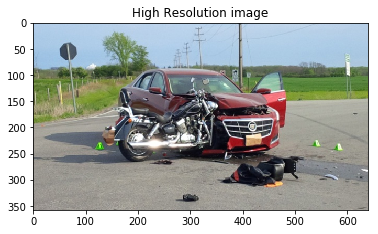

In [63]:
plt.figure()
plt.imshow(cv2.cvtColor(HR[index].astype(np.uint8) , cv2.COLOR_BGR2RGB) )
plt.title("High Resolution image")

Text(0.5, 1.0, 'Super Resolution image')

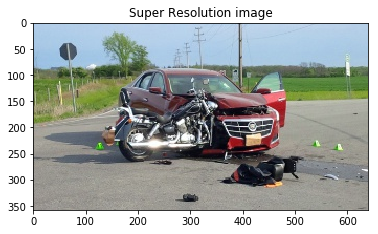

In [61]:
plt.figure()
plt.imshow(cv2.cvtColor(picture, cv2.COLOR_BGR2RGB));
plt.title("Super Resolution image")

# Advanced algorithm (Xgboost)

In [77]:
from xgboost import XGBRegressor    

model = XGBRegressor()

### 1. Tuning Model

##### Grid Search

In [75]:
start = time.time()

from xgboost import XGBRegressor    

start = time.time()

model_list_xgb = []
model = XGBRegressor(n_jobs = 6,
                     eval_metric = 'rmse',
                     random_state = seed)

params_xgb = {'n_estimators' : [100, 200,300],
              'learning_rate':[0.01,0.1,0.2,0.3],
              'min_child_weight':[4,5], 
              'gamma':[i/10.0 for i in range(3,6)],  
              'subsample':[i/10.0 for i in range(6,11)],
              'colsample_bytree':[i/10.0 for i in range(6,11)], 
              'max_depth': [2,3,4]
             }


best_param = grid_search_all_model(X_train,y_train,model,params_xgb)

    
end = time.time()
print('Time:',end - start)

In [106]:
start = time.time()

model_list_xgb = []
for i in np.arange(12):
    model_list_xgb.append(XGBRegressor(learning_rate = 0.1,
                                        n_jobs = 8,
                                        n_estimators = 200,
                                       colsample_bytree = 0.3,
                                       max_depth = 4, 
                                       alpha = 10,
                                        random_state = seed))
    
end = time.time()
print('Time:',end - start)

Time: 0.002370595932006836


##### Cross Validation

In [96]:
start = time.time()

val_error,tr_error = cross_validation(X_train,y_train,model_list_xgb,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)

 Validation PSNR: [26.0, 26.15, 26.11] 
 Train PSNR: [27.09, 27.03, 27.04] 


Time: 202.69407320022583


### 2. Make Prediction

###### Train models

In [107]:
start = time.time()

fit_models(X_train,y_train,model_list_xgb)

end = time.time()
print('Time:',end - start)

Time: 35.6305410861969


###### Predict Test set

In [108]:
start = time.time()

prediction = Predict_test(X_test,model_list_xgb)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

PSNR: 26.132073792860407 


Time: 0.658897876739502


###### Super resolution sample image

Use the first image as example.

In [88]:
index = 0

picture,PSNR = super_resolution(LR[index],HR[index],model_list_xgb)
print('PSNR is {:.3}'.format(PSNR))

PSNR is 32.4


<IPython.core.display.Javascript object>


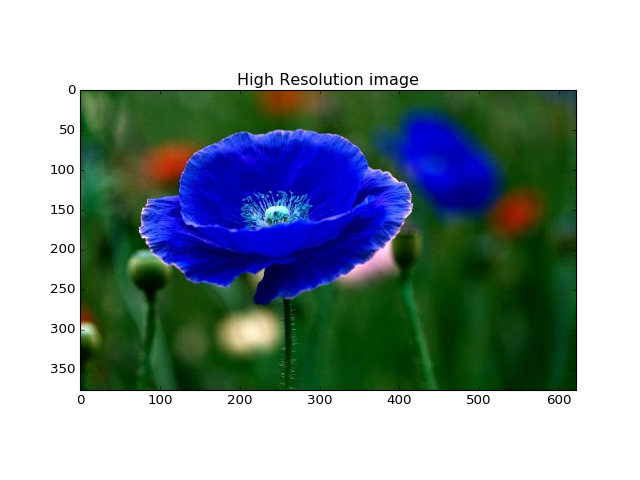

In [90]:
plt.figure()
plt.imshow(cv2.cvtColor(HR[index].astype(np.uint8) , cv2.COLOR_BGR2RGB) )
plt.title("High Resolution image")

<IPython.core.display.Javascript object>


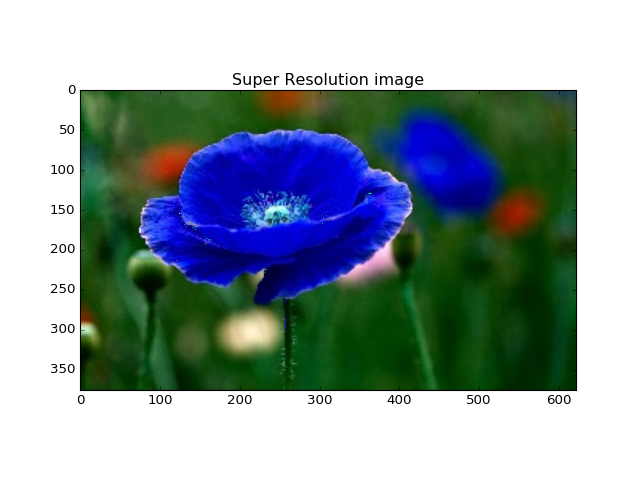

In [74]:
plt.figure()
plt.imshow(cv2.cvtColor(picture , cv2.COLOR_BGR2RGB));
plt.title("Super Resolution image")

# Advanced algorithm (Light GMB)

In [ ]:
import lightgbm as lgb

### 1. Tuning Model

##### Grid Search

In [ ]:
parameters_tunning = {
    'learning_rate':[0.01, 0.1, 0.2, 0.3], # tuning (started with higher learning rate), hight value --> overfit
    'min_child_samples' : [2, 4,8,10], # tuning, similar to min_samples_samples

model = lgb.LGBMRegressor()

In [ ]:
start = time.time()
best = grid_search_all_model(X_train,y_train,model,parameters_tunning,cv = 3)

end = time.time()
print('Time:',end - start)

In [ ]:
best

##### Cross Validation

In [ ]:
start = time.time()
model_list_lgb = []
for i in np.arange(12):
    model_list_lgb.append(lgb.LGBMModel(**best[i],
                                        n_jobs = 6,
                                        n_estimators = 200,
                                        random_state = seed,
                                        objective='regression'))

print(model_list_lgb[0])
val_error,tr_error = cross_validation(X_train,y_train,model_list_lgb,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)

In [ ]:
### 2. Make Prediction

In [ ]:
start = time.time()

prediction = Prediction(X_train,y_train,X_test,model_list_lgb,test = True)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

# Improved Model (Random Forest)

In [22]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()

### 1. Tuning Model

##### Grid Search

In [17]:
parameters_rf = {
    'n_estimators':[30,50], # number of trees
    'min_samples_split' : [5, 10, 15], # minimum number of samples required to split a node
    'min_samples_leaf' : [4,8,12] # minumum number of samples required at each leaf node
}

In [18]:
start = time.time()
best_rf = grid_search_all_model(X_train,y_train,model_rf,parameters_rf,cv = 3)

end = time.time()
print('Time:',end - start)

Model 0
Best params {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50}
Best MSE: 115.32947247352763
Model 1
Best params {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50}
Best MSE: 112.06512840542544
Model 2
Best params {'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50}
Best MSE: 115.04031714538407
Model 3
Best params {'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50}
Best MSE: 112.37062932251325
Model 4
Best params {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50}
Best MSE: 108.02721502628971
Model 5
Best params {'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50}
Best MSE: 104.17313403105993
Model 6
Best params {'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50}
Best MSE: 107.49809473576552
Model 7
Best params {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50}
Best MSE: 104.15429333498211
Model 8
Best params {'min_samples_leaf': 12, 'min_s

In [20]:
best_rf = [{'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50},
{'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50}]

In [23]:
start = time.time()

model_list_rf = []

for i in np.arange(12):
    model_list_rf.append(RandomForestRegressor(**best_rf[i],random_state = seed))

end = time.time()
print('Time:',end - start)

Time: 0.0009648799896240234


##### Cross Validation

In [25]:
start = time.time()

val_error,tr_error = cross_validation(X_train,y_train,model_list_rf,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)


 Validation PSNR: [26.07, 26.22, 26.23] 
 Train PSNR: [27.73, 27.66, 27.65] 


Time: 1077.2700400352478


### 2. Make Prediction

##### Train models

In [24]:
start = time.time()

fit_models(X_train,y_train,model_list_rf)

end = time.time()
print('Time:',end - start)

Time: 296.5581569671631


##### Predict Test set

In [25]:
start = time.time()

prediction = Predict_test(X_test,model_list_rf)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

PSNR: 26.147180400913353 


Time: 4.360445737838745


Text(0.5, 1.0, 'Super Resolution image')

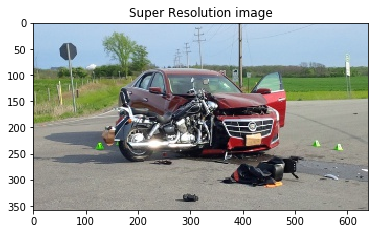

In [30]:
index = 0

picture = super_resolution_LR(LR[index],model_list_rf)
plt.figure()
plt.imshow(cv2.cvtColor(picture, cv2.COLOR_BGR2RGB));
plt.title("Super Resolution image")

# Super Resolution for Test LR Images

In [33]:
test_path = "../data/test_set/*.jpg"
save_path = "../figs/SR_I/"
def super_resolution_test(t_path, s_path,model_list):
    for file in glob.glob(t_path):
        name = file[-12::]
        LR = cv2.imread(file).astype(np.float32)
        picture = super_resolution_LR(LR,model_list)
        cv2.imwrite(os.path.join(s_path , name), picture)

In [34]:
start = time.time()

super_resolution_test(test_path, save_path,model_list_rf)

end = time.time()
print('Time:',end - start)

Time: 67.02473139762878
